# Digit Recogniser

Filename: digit-recogniser.ipynb \
Author: Timothy Holland \
Last updated: 25/05/2024 \
Kaggle competition: https://www.kaggle.com/c/digit-recognizer/data

## Data Processing

Train data shape: (42000, 784)
Test data shape: (28000, 784)

Label distribution:
label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: count, dtype: int64


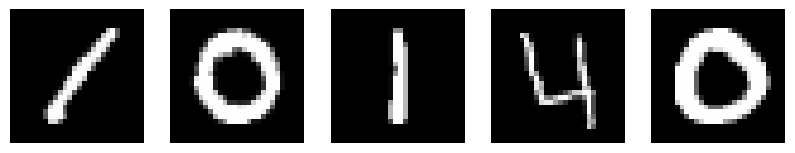

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']

# Basic info
print("Train data shape:", X_train.shape)
print("Test data shape:", test_data.shape)
print("\nLabel distribution:")
print(y_train.value_counts().sort_index())

# Visualize some digits
def plot_digits(data, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i, ax in enumerate(axes):
        img = data.iloc[i].values.reshape(28, 28)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

plot_digits(X_train)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


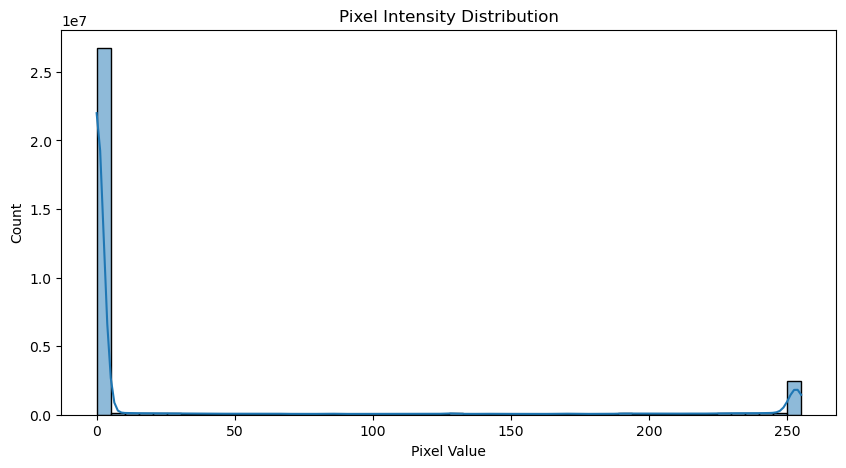

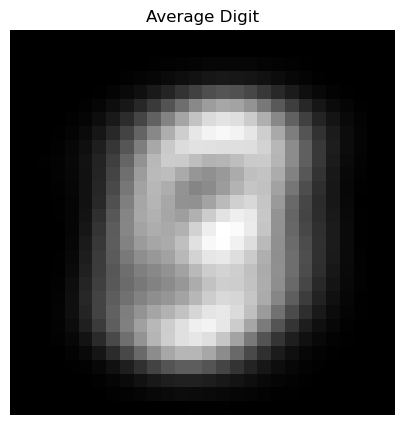

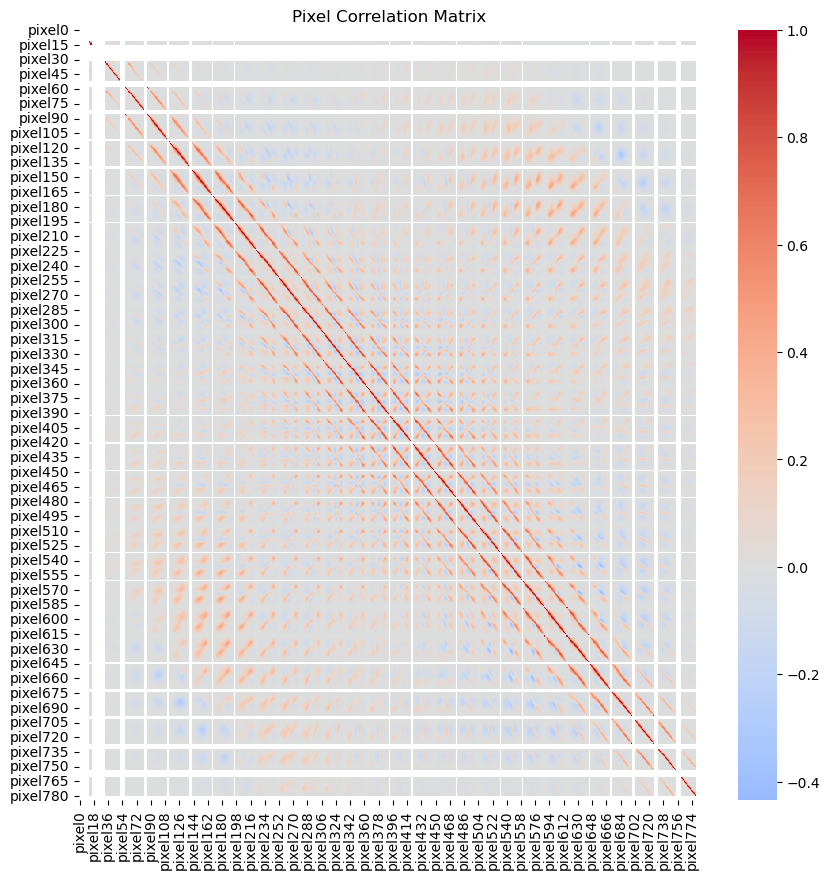

In [2]:
# Pixel intensity distribution
plt.figure(figsize=(10, 5))
sns.histplot(X_train.values.ravel(), bins=50, kde=True)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.show()

# Average digit
plt.figure(figsize=(5, 5))
plt.imshow(X_train.mean().values.reshape(28, 28), cmap='gray')
plt.title('Average Digit')
plt.axis('off')
plt.show()

# Correlation between pixels
corr_matrix = X_train.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Pixel Correlation Matrix')
plt.show()

#### Data normalisation

In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data

# Normalize the data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Print the shapes of the normalized data
print("Normalized training data shape:", X_train_normalized.shape)
print("Normalized testing data shape:", X_test_normalized.shape)

Normalized training data shape: (42000, 784)
Normalized testing data shape: (28000, 784)


#### Data augmentation

In [69]:
import numpy as np
import imgaug.augmenters as iaa
from imgaug.augmentables.batches import UnnormalizedBatch

# Assuming X_train_normalized and y_train are your normalized training data and labels
# with shapes (42000, 784) and (42000,) respectively

# Reshape the data to the expected format
X_train_reshaped = X_train_normalized.reshape(-1, 28, 28, 1)

# Convert the data type to a supported format (e.g., float32)
X_train_reshaped = X_train_reshaped.astype(np.float32)

# Define the augmentation sequence
seq = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10)),
    iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}),
    iaa.Affine(scale=(0.9, 1.1)),
    iaa.Affine(shear=(-5, 5)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05))
])

# Function to apply augmentation
def augment_batch(images, labels):
    batch = UnnormalizedBatch(images=images, data=labels)
    augmented_batch = seq(images=batch.images_unaug)
    return augmented_batch, batch.data

# Generate augmented data
augmented_images = []
augmented_labels = []

for i in range(len(X_train_reshaped)):
    aug_img, aug_label = augment_batch(X_train_reshaped[i:i+1], [y_train[i]])
    augmented_images.extend(aug_img)
    augmented_labels.extend(aug_label)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images).reshape(-1, 28, 28, 1)
augmented_labels = np.array(augmented_labels)

# Combine original and augmented data
X_train_augmented = np.concatenate([X_train_reshaped, augmented_images])
y_train_augmented = np.concatenate([y_train, augmented_labels])

print("Original training data shape:", X_train_reshaped.shape)
print("Augmented training data shape:", X_train_augmented.shape)

Original training data shape: (42000, 28, 28, 1)
Augmented training data shape: (84000, 28, 28, 1)


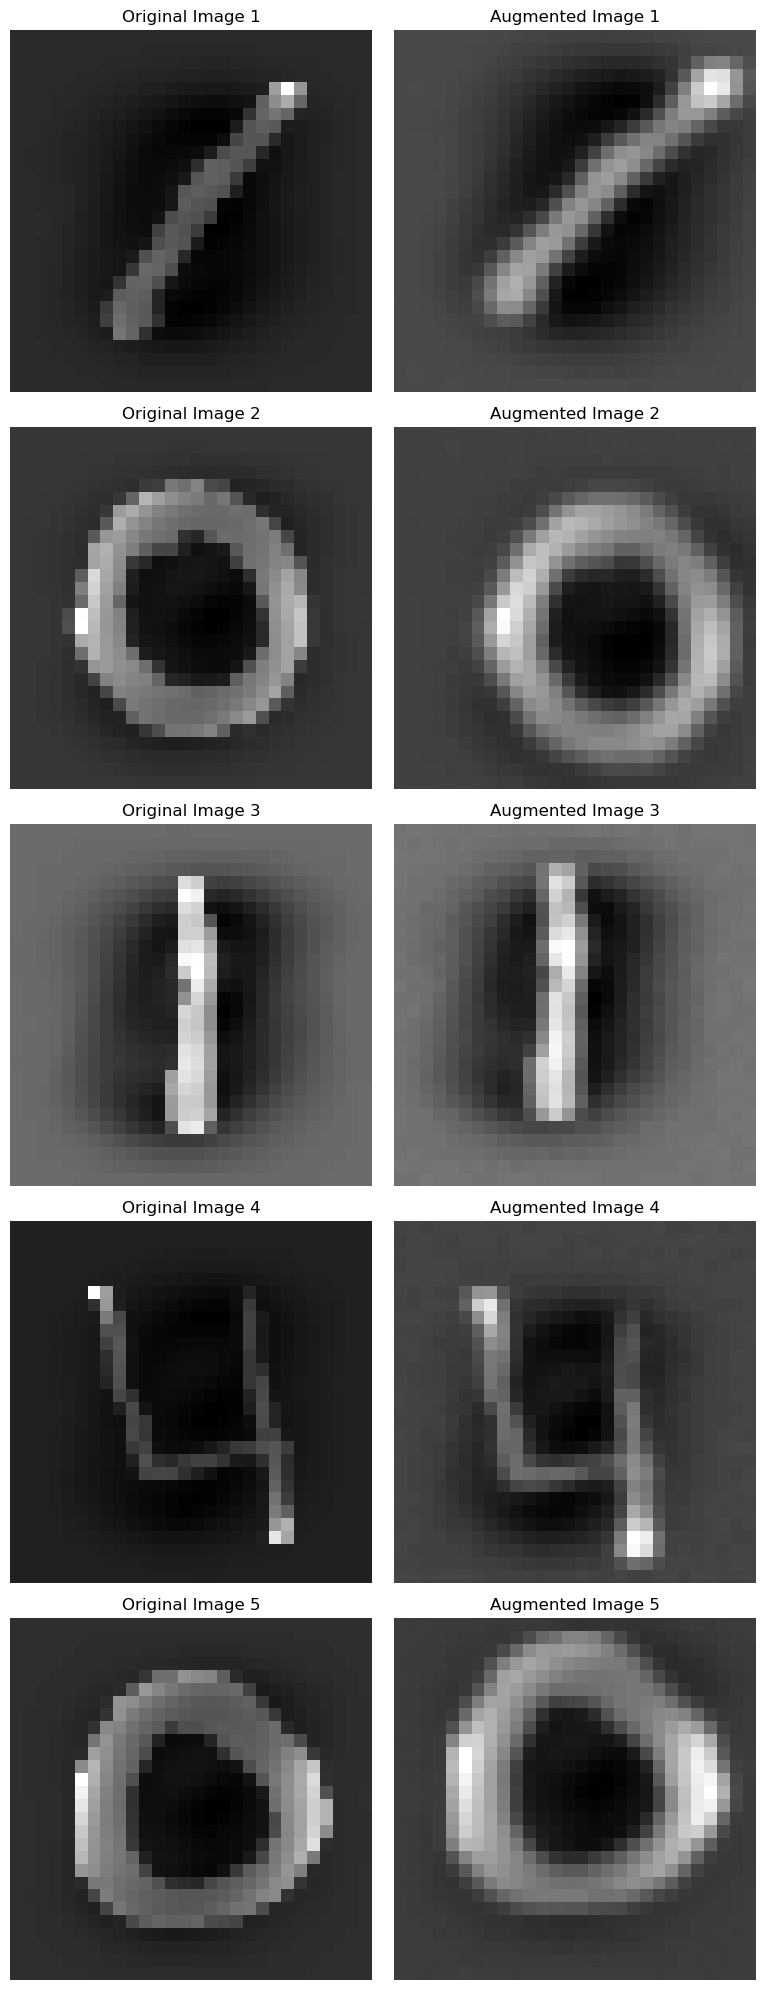

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot original and augmented images side by side
def plot_comparison(original_images, augmented_images, num_instances=5):
    fig, axes = plt.subplots(num_instances, 2, figsize=(8, num_instances*4))
    
    for i in range(num_instances):
        # Plot original image
        axes[i, 0].imshow(original_images[i].reshape(28, 28), cmap='gray')
        axes[i, 0].set_title(f"Original Image {i+1}")
        axes[i, 0].axis('off')
        
        # Plot augmented image
        axes[i, 1].imshow(augmented_images[i].reshape(28, 28), cmap='gray')
        axes[i, 1].set_title(f"Augmented Image {i+1}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Select a few initial instances from the original dataset
num_instances = 5
original_instances = X_train_reshaped[:num_instances]

# Generate augmented instances for the selected original instances
augmented_instances = []
for i in range(num_instances):
    aug_img, _ = augment_batch(original_instances[i:i+1], [0])  # Labels are not used here
    augmented_instances.extend(aug_img)

augmented_instances = np.array(augmented_instances)

# Plot the comparison
plot_comparison(original_instances, augmented_instances, num_instances)

Original Dataset:


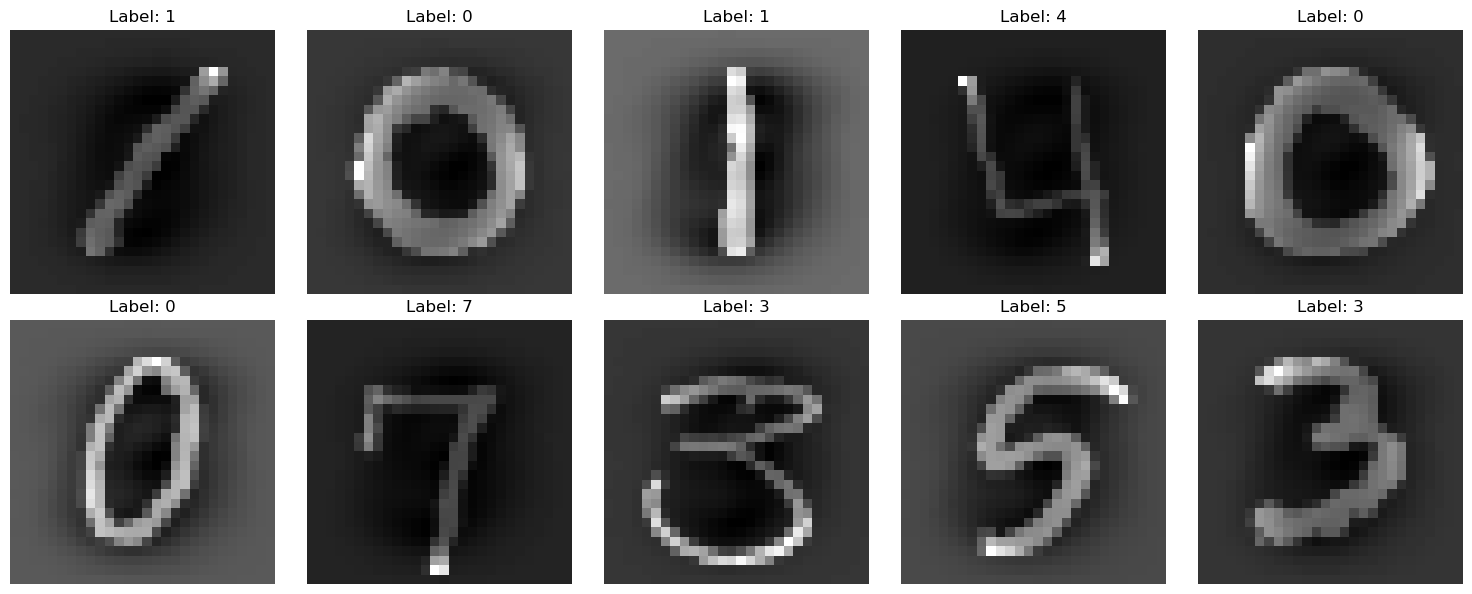

Augmented Dataset:


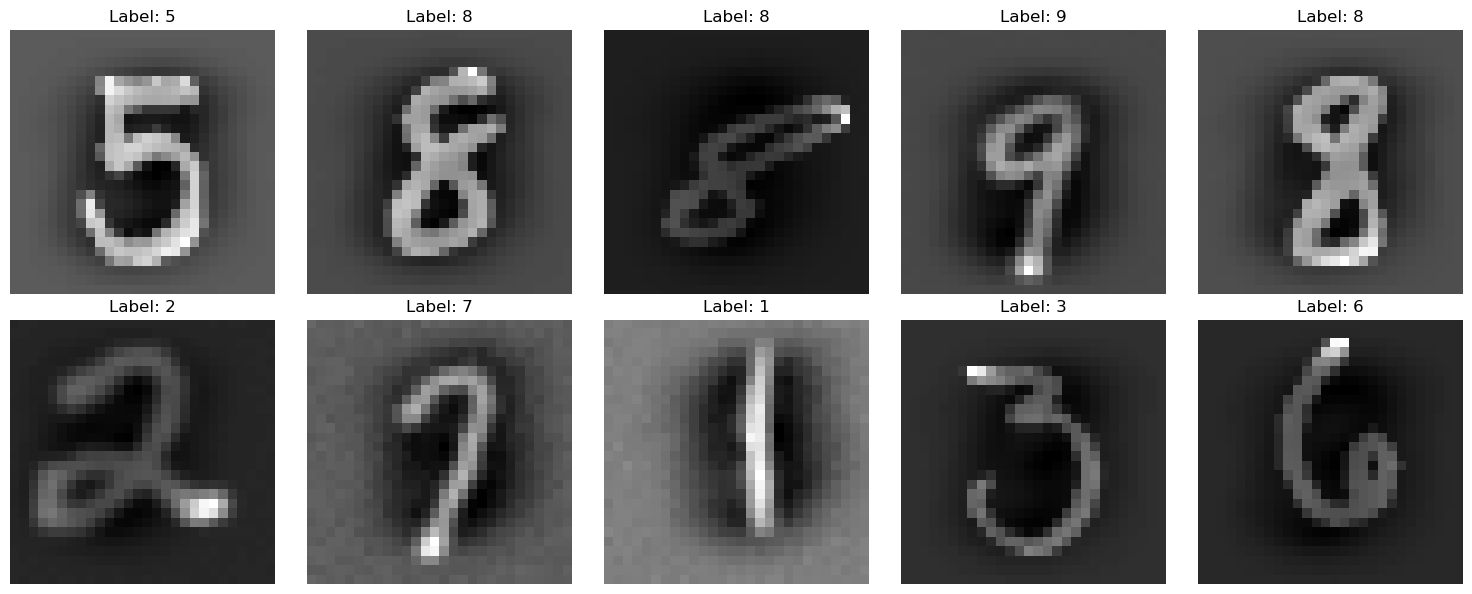

In [27]:
import matplotlib.pyplot as plt

# Function to display images with their labels
def display_images(images, labels, num_images=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i in range(num_images):
        ax = axes[i]
        image = images[i].reshape(28, 28)
        label = labels[i]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

# Display some instances from the original dataset
print("Original Dataset:")
display_images(X_train_reshaped, y_train, num_images=10)

# Display some instances from the augmented dataset
print("Augmented Dataset:")
augmented_indices = np.random.choice(len(X_train_augmented), size=10, replace=False)
augmented_images = X_train_augmented[augmented_indices]
augmented_labels = y_train_augmented[augmented_indices]
display_images(augmented_images, augmented_labels, num_images=10)

## Model

In [61]:
X_train_final = X_train_normalized
y_train_final = y_train

X_train_reshaped = X_train_normalized.reshape(-1, 28, 28, 1)
X_train_final = X_train_reshaped

print(X_train_final.shape)
print(y_train_final.shape)

(42000, 28, 28, 1)
(42000,)


#### CNN

In [64]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Assuming X_train_final and y_train_final are already loaded

# Split the data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_final, y_train_final, test_size=0.2, random_state=42)

# Preprocess the target variables
y_train_split = to_categorical(y_train_split)
y_val = to_categorical(y_val)

# Model layout
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(X_train_split, y_train_split, epochs=10, batch_size=64, 
                    validation_data=(X_val, y_val))

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_accuracy:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,714 (221.54 KB)

 Trainable params: 56,714 (221.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6892 - loss: 0.9445 - val_accuracy: 0.9614 - val_loss: 0.1258
Epoch 2/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9384 - loss: 0.2082 - val_accuracy: 0.9746 - val_loss: 0.0823
Epoch 3/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7624 - loss: 0.7970 - val_accuracy: 0.9426 - val_loss: 0.3180
Epoch 4/10
525/525 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7931 - loss: 0.6702 - val_accuracy: 0.3230 - val_loss: 2.1006
Epoch 5/10
523/525 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3025 - loss: 2.0643

KeyboardInterrupt: 